### Loading libraries

In [3]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 200
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

params = {'legend.fontsize': 'small',
         'axes.labelsize': 'small',
         'axes.titlesize':'small',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small',
         'figure.figsize': (3, 2)}
plt.rcParams.update(params)
  
import os
import glob
import re
import itertools
import collections
from collections import Counter
import math
import random
from random import randrange
import string
import subprocess

import numpy as np
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
import seaborn as sns
cmap = sns.cm.rocket_r
sns.set_style("white")

import anndata
from anndata import read_h5ad
from anndata import AnnData
import phylopandas as ph


### Loading directories

In [145]:
mainDir = '/oak/stanford/groups/quake/gita/raw/tab1_20200407/thirdAnalysis/10x/'
mainDir10 ='/oak/stanford/groups/quake/gita/raw/tab3-14_20210420/all/'
#first loading in the taxonomy database
dbDir = '/oak/stanford/groups/quake/gita/raw/database/taxonomyNCBI20200125/'
#directory of the object containing all count table for tsp1-15
objpath='/oak/stanford/groups/quake/gita/raw/tab2_20200508/objects/tSP1_TSP15_scvi_donor-method_normalized-log1p-scaled_annotated.h5ad'

tax = pd.read_csv(dbDir + 'ncbi_lineages_2021-01-26.csv')
#want to take only the following columns from the lineage dataframe tax 
tax_short=tax[['tax_id','superkingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species']]

### Kraken2 - processing done on each hit filter (euk_filter.py)  - already ran using snakemake pipeline
0- gets rid of Unclassified category of hits\
1- adds sample and donor information based on file name\
2- adds lineage information to .tab nt results\
3- further filters results to eliminate hits from certain euk lineages (e.g. chordates)\
4- further eliminates poor taxonomies (e.g. no species information)\
5- creates several columns: sample2, bc, cell_bc, cell_id all so that we can merge with 
the tabula sapiens object on cell_id column once we read the results

In [ ]:
#first loading in the taxonomy database
dbDir = '/oak/stanford/groups/quake/gita/raw/database/taxonomyNCBI20200125/'
tax = pd.read_csv(dbDir + 'ncbi_lineages_2021-01-26.csv')
#want to take only the following columns from the lineage dataframe tax 
tax_short=tax[['tax_id','superkingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species']]


#the tab file that we want to filter
file=snakemake.input[0]
#the filtered csv file we want to create
outputfile=snakemake.output[0]

#will only select files that are not empty 
if os.stat(file).st_size != 0:
    filename = file.split('/')[-1].split('.tab')[0]
    df = pd.read_csv(file, delimiter ='\t')
    df.columns=['classified', 'seqid', 'pathogen', 'notsure', 'lca']

    #first, I only want the classified reads
    df_c = df[df['classified']=='C']
    #adding sample and donor information
    df_c['sample'] = [filename]*df_c.shape[0]
    df_c['donor'] = [filename.split('_')[0]]*df_c.shape[0]
    
    #adding lineage information
    df_c['tax_id']=df_c['pathogen'].apply(lambda x: int(x.split('(taxid')[1].split(')')[0]))
    #want to take only the following columns from the lineage dataframe tax 
    tax_short=tax[['tax_id','superkingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species']]
    #merging the  dataframe (for which we have taxid and merging it with tax_short for lineage informatin)
    df_c_lin=df_c.merge(tax_short, on='tax_id', how='left')
    
    #now I want to exclude all the unwanted eukaryotes
    df_c_lin_fil = df_c_lin[~df_c_lin['phylum'].isin(['Chordata','Streptophyta','Arthropoda',
                                                'Mollusca','Annelida','Chlorophyta'])]

    #phylum filter (only selecting taxonomic lineages that have species level information)
    df_c_lin_fil_sp = df_c_lin_fil[~df_c_lin_fil['species'].isna()]
        
    #these are all the transformations so that need to be made to match the seqid (barcodes) and sample information to the TS object cell_identifier 
    #The final format is cellular barcode_sample (without some of the extensions)
    df_c_lin_fil_sp['sample'] = df_c_lin_fil_sp['sample'].apply(lambda x: x.split('.tab')[0])
    df_c_lin_fil_sp['sample2'] = df_c_lin_fil_sp['sample'].apply(lambda x: '_'.join(x.split('_')[:-2]))
    df_c_lin_fil_sp['bc'] = df_c_lin_fil_sp['seqid'].apply(lambda x: '_'.join(x.split('_')[-2:]))
    df_c_lin_fil_sp['cell_bc'] = df_c_lin_fil_sp['bc'].apply(lambda x: x.split('_')[0])
    df_c_lin_fil_sp['cell_id']= df_c_lin_fil_sp['cell_bc'] + '_' + df_c_lin_fil_sp['sample2']

    #POST FILTERING: if no reads survive, we're writing a dummy fasta file so snakemake doesn't fail
    if df_c_lin_fil_sp.shape[0]==0:
        with open(outputfile,'w+') as output_file:
            output_file.write(">dummy_sequence")
    else:
        df_c_lin_fil_sp.to_csv(snakemake.output[0])

#what to do with empty files: we're going to create empty "filtered" files so that snakemake doesn't fail going forward. 
else:
    with open(outputfile, "w+") as output_file:
        output_file.write(">dummy_sequence")
        

### Some more processing using getSeqsForHits.py (also included in snk pipeline)
0- opens the processed csvs and merges them with the classified.fasta file to obtain a sequence for each hit. output is in nt_processed_withSeqs/

In [ ]:
file=snakemake.input[0] #processed csv hit results
file2=snakemake.input[1] #classified fasta file

#will only select files that are not empty (i.e have output)
if os.stat(file).st_size != 0:
	df0=pd.read_csv(file)
    #Reading in the original fasta file, quickly converting it to dataframe, merging that dataframe with hit output dataframe to get seqs
	df1=ph.read_fasta(snakemake.input[1])
	df1=df1.rename(columns={'id':'seqid', 'sequence': 'seq'})
	df1=df1[['seqid', 'seq']]

    #merging the hit dataframe with another that contains information about sequences
	final= df0.merge(df1, on='seqid', how= 'inner')
	final.to_csv(snakemake.output[0], index=False)

#what to do with empty .tab blast results: we're going to create empty csv's so that snakemake doesn't fail going forward. 
else:
	pd.DataFrame({}).to_csv(snakemake.output[0], index=False)

### Reading in the total tsp1-15 object to merge with hit results 

In [ ]:
#about 41Gig, (503886, 50) dimension
total = sc.read_h5ad(objpath)
#getting the 10x data only
total_10x = total[total.obs['method']=='10X']
obj_meta = total_10x.obs
obj_meta.to_csv(mainDir10 + 'obj_meta.csv', index=False)

### Reading the object obs dataframe for tsp1-15

In [4]:
obj_meta = pd.read_csv(mainDir10 + 'obj_meta.csv')

/home/users/gitam/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning:

Columns (0,1,3,7,8,10) have mixed types.Specify dtype option on import or set low_memory=False.



### Read tsp1-16 processed SIMBA output 
excluding synthetic constructs and cloning vectors

In [1]:
all_hits = pd.read_csv(mainDir10 + 'all_nt_processed_withseqs_aug27.csv')

#adding column information since I removed headings when I cat csv files
all_hits.columns = ['Unnamed: 0','classified','seqid','pathogen','notsure','lca','sample','donor',
                    'tax_id','superkingdom','phylum','class','order','family','genus','species',
                    'sample2','bc','cell_bc','cell_id','seq']
#removing any synthetic constructs 
all_hits = all_hits[~all_hits['species'].str.contains('synthetic construct|Cloning vector', case=False)]

NameError: name 'pd' is not defined

### Viral, Bacterial, Eukaryotic and Archaeal dataframes 
dividing into smaller csvs so I can more easily open them 

In [9]:
all_hits_vir = all_hits[all_hits['superkingdom']=='Viruses']
all_hits_vir.drop(columns=['Unnamed: 0', 'classified', 'notsure'],inplace=True)
all_hits_vir.to_csv(mainDir10 + 'all_nt_processed_withseqs_aug27_vir.csv')

In [10]:
all_hits_bac = all_hits[all_hits['superkingdom']=='Bacteria']
all_hits_bac.drop(columns=['Unnamed: 0', 'classified', 'notsure'],inplace=True)
all_hits_bac.to_csv(mainDir10 + 'all_nt_processed_withseqs_aug27_bac.csv')

In [11]:
all_hits_euk = all_hits[all_hits['superkingdom']=='Eukaryota']
all_hits_euk.drop(columns=['Unnamed: 0', 'classified', 'notsure'],inplace=True)
all_hits_euk.to_csv(mainDir10 + 'all_nt_processed_withseqs_aug27_euk.csv')

In [12]:
all_hits_arch = all_hits[all_hits['superkingdom']=='Archaea']
all_hits_arch.drop(columns=['Unnamed: 0', 'classified', 'notsure'],inplace=True)
all_hits_arch.to_csv(mainDir10 + 'all_nt_processed_withseqs_aug27_arch.csv')

In [195]:
print('number of viral hits; ', all_hits_vir.shape[0]) #~53 million hits
print('number of bacterial hits; ', all_hits_bac.shape[0]) #~16 million hits
print('number of eukaryotic hits; ', all_hits_euk.shape[0]) #~23 million hits
print('number of archaeal hits; ', all_hits_arch.shape[0]) #~1 million hits


number of viral hits;  53304692
number of bacterial hits;  16309977
number of eukaryotic hits;  23875120
number of archaeal hits;  984692


### Getting a dataframe of Kraken hits to BLAST 
goal is to select n number of reads from each species (species that have a count above 100 across the total dataset) and re-blast to confirm their identiy and presence. 

In [357]:
sp_counts_bac=all_hits_bac.species.value_counts().to_frame('count')
sp_counts_bac = sp_counts_bac.reset_index()
sp_counts_bac.rename(columns={'index':'species'}, inplace=True)
all_hits_bac = all_hits_bac.merge(sp_counts_bac, on='species')
# all_hits_bac_fil = all_hits_bac[all_hits_bac['count']>100]

In [368]:
#shuffling a dataframe before the next operation to make sure selected reads are randomly coming from different samples
all_hits_bac_fil = all_hits_bac_fil.sample(frac = 1)


In [724]:
def getLcas(x):
    vec=[]
#     print(x)
    for item in x:
        item = str(item.split(':')[0])
        if (item!='A') & (item!='0') &  (item!='1'):
            vec.append(item)
    return(vec)


def carp(x):  
    if '7962' in x:
        pred='yes'
    else:
        pred='no'
    return(pred)

In [534]:
df=all_hits_bac
%timeit df['lca_vec'] = df['lca'].apply(lambda x: x.split(' '))


21.6 s ± 473 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [535]:
%timeit df['lca_main'] = df['lca_vec'].apply(lambda x: getLcas(x))


1min ± 514 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [536]:
%timeit df['carp'] = df['lca_main'].apply(lambda x: carp(x))

5.11 s ± 123 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [565]:
df.to_csv(mainDir10 + 'all_nt_processed_withseqs_aug27_bac_v2.csv')

In [603]:
%timeit all_hits_vir=pd.read_csv(mainDir10 + 'all_nt_processed_withseqs_aug27_vir.csv')


6min 31s ± 40.4 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [608]:
df=all_hits_vir


UsageError: Line magic function `%%timeit` not found.


In [612]:
%%timeit 
df['lca_vec'] = df['lca'].apply(lambda x: x.split(' '))


/home/users/gitam/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



1min 16s ± 3.25 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [613]:
%%timeit 

df['lca_main'] = df['lca_vec'].apply(lambda x: getLcas(x))

/home/users/gitam/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3min 32s ± 2.94 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [614]:
%%timeit 
df['carp'] = df['lca_main'].apply(lambda x: carp(x))


/home/users/gitam/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



18.7 s ± 643 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [618]:
df_carp = df[df['carp']=='yes']

In [626]:
df_fil = df[df['carp']=='no']

In [620]:
df_carp.shape[0]/df.shape[0]

0.2818247406813644

In [622]:
df_carp.pathogen.value_counts().head(20)

Myoviridae sp. (taxid 2202564)                                             11254067
Caudovirales sp. (taxid 2202568)                                            1226605
Carnation latent virus (taxid 12164)                                         720852
Siphoviridae sp. (taxid 2170413)                                             505712
Rice black streaked dwarf virus (taxid 10990)                                421780
Podoviridae sp. (taxid 2202567)                                              332725
Bovine viral diarrhea virus 1 (taxid 11099)                                  210235
Ruhugu virus (taxid 2652755)                                                  97075
Bacteriophage sp. (taxid 38018)                                               82309
Human gammaherpesvirus 4 (taxid 10376)                                        27670
Porcine bastrovirus (taxid 2588662)                                           24128
uncultured Caudovirales phage (taxid 2100421)                               

In [616]:
%%timeit 
df.to_csv(mainDir10 + 'all_nt_processed_withseqs_aug27_vir_v2.csv')

KeyboardInterrupt: 

In [ ]:
%%timeit 
all_hits_euk=pd.read_csv(mainDir10 + 'all_nt_processed_withseqs_aug27_euk.csv')


In [ ]:
df= all_hits_euk


In [ ]:
%%timeit 
df['lca_vec'] = df['lca'].apply(lambda x: x.split(' '))


In [ ]:
%%timeit 
df['lca_main'] = df['lca_vec'].apply(lambda x: getLcas(x))

In [ ]:
%%timeit 
df['carp'] = df['lca_main'].apply(lambda x: carp(x))

In [ ]:
df.to_csv(mainDir10 + 'all_nt_processed_withseqs_aug27_euk_v2.csv')

In [572]:
bac_df = pd.read_csv(mainDir10 + 'all_nt_processed_withseqs_aug27_bac_v2.csv')

/home/users/gitam/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning:

Columns (8,9,10,11,12) have mixed types.Specify dtype option on import or set low_memory=False.



In [576]:
bac_df_fil = bac_df[bac_df['carp']=='no']

In [587]:
fish = bac_df[bac_df['carp']=='yes']

In [588]:
no = bac_df_fil.pathogen.value_counts().to_frame().reset_index()
yes=fish.pathogen.value_counts().to_frame().reset_index()
mer = no.merge(yes, on='index', how='left')
mer[mer['pathogen_y'].isna()].head(50)


,index,pathogen_x,pathogen_y
790,uncultured Streptobacillus sp. (taxid 316096),1640,NaN
1189,Anaerolinea thermophila (taxid 167964),1273,NaN
1947,Mannheimia haemolytica D153 (taxid 1261126),924,NaN
2136,uncultured Anoxybacillus sp. (taxid 263860),865,NaN
3012,Sphingomonas sp. ALBL_100 (taxid 1811331),659,NaN
4666,beta proteobacterium ASRB7-5 (taxid 434903),402,NaN
4716,Spiroplasma endosymbiont of Heliconius timaret...,396,NaN
4893,uncultured Salinicola sp. (taxid 1193542),372,NaN
5042,Micrococcus sp. ALBL_223 (taxid 1811305),353,NaN
5047,Alicyclobacillus vulcanalis (taxid 252246),353,NaN


### Comparing blast and kraken
- only taking on viruses, bacteria, fungi hits with species-level classification for sample TSP2_Bladder_NA_10X_1_1_S5_L001
- calculating precision, recall, and F1, using blast calls as true calls. 
- repeating those calculations for phylum level classification.

#### Bla

In [712]:
#sample that I want to compare to TSP2_Bladder_NA_10X_1_1_S5_L001
#result can be found in test_lin
#I have checked to see if all these blast jobs have run to completion, and they have. 
test_path= '/oak/stanford/groups/quake/gita/raw/tab2_20200508/tab2microbial/thirdAnalysis/'
file = test_path + 'virNTblastn/TSP2_Bladder_NA_10X_1_1_S5_L001.tab'
file2 = test_path + 'micoNT_blastn/TSP2_Bladder_NA_10X_1_1_S5_L001.tab'
file3 = test_path + 'fungi_NT_blastn/TSP2_Bladder_NA_10X_1_1_S5_L001.tab'

test_vir = pd.read_csv(file, delimiter='\t')
test_mico = pd.read_csv(file2, delimiter='\t')
test_fungi = pd.read_csv(file3, delimiter='\t')

filename = file.split('/')[-1].split('.tab')[0]

test_vir.columns=['seqName','refName','pathogen','bitscore','pident','evalue','gapopen','qstart','qend','sstart',
'send','length','mismatch','staxids']

test_mico.columns=['seqName','refName','pathogen','bitscore','pident','evalue','gapopen','qstart','qend','sstart',
'send','length','mismatch','staxids']

test_fungi.columns=['seqName','refName','pathogen','bitscore','pident','evalue','gapopen','qstart','qend','sstart',
'send','length','mismatch','staxids']

test=pd.concat([test_vir, test_mico, test_fungi])

test['sample'] = [filename]*test.shape[0]
test['donor'] = [filename.split('_')[0]]*test.shape[0]

test.rename(columns={'staxids': 'tax_id'}, inplace=True)
test_lin=test.merge(tax_short, on='tax_id', how='left')
bla = test_lin


/home/users/gitam/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning:

Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.



#### kraken2

In [744]:
# now finding the equivalent kraken file. 
# result found in test2_lin
file = mainDir10 + 'nt_processed_withseqs/TSP2_Bladder_NA_10X_1_1_S5_L001.csv'
filename = file.split('/')[-1].split('.tab')[0]
kra = pd.read_csv(file)

#### now taking in only viruses, bacteria and fungi and taking out hits that don't have species or phylum classification (depending on the analysis)

In [719]:
bla_vir=bla[bla['superkingdom']=='Viruses']
bla_bac=bla[bla['superkingdom']=='Bacteria']
bla_euk=bla[bla['superkingdom']=='Eukaryota']
bla_euk_fil = bla_euk[~bla_euk.phylum.isna()]
bla_euk_fil = bla_euk_fil[bla_euk_fil.phylum.str.contains('myco', case=False)]
bla_all = pd.concat([bla_vir,bla_bac,bla_euk_fil ])
#taking out entries that don't have species annotation from both datasets 
bla_all_spfil = bla_all[~bla_all.species.isna()]
#taking out entries that don't have phylum annotation from both datasets 
bla_all_phfil = bla_all[~bla_all.phylum.isna()]


In [745]:
kra_vir=kra[kra['superkingdom']=='Viruses']
kra_bac=kra[kra['superkingdom']=='Bacteria']
kra_euk=kra[kra['superkingdom']=='Eukaryota']
kra_euk_fil = kra_euk[~kra_euk.phylum.isna()]
kra_euk_fil = kra_euk_fil[kra_euk_fil.phylum.str.contains('myco', case=False)]
kra_all = pd.concat([kra_vir,kra_bac,kra_euk_fil])
kra_all_spfil = kra_all[~kra_all.species.isna()]
#taking out entries that don't have phylum annotation from both datasets 
kra_all_phfil = kra_all[~kra_all.phylum.isna()]


#### calculating the precision, recall, and F1, assuming blast hits provide true values (SPECIES level classification)

In [746]:
#these are the species that are only found in blast dataset, so they represent false negatives
bla_only=set(bla_all_spfil.species) - set(kra_all_spfil.species)
fn=len(bla_only)
print('number of false negatives: ', fn)
#these are the species that are only found in kraken dataset, so they represent false positives
kra_only=set(kra_all_spfil.species) - set(bla_all_spfil.species)
fp=len(kra_only)
print('number of false positives: ', fp)

#these are species that are found across both datasets so they represent true positives
kra_bla=set(kra_all_spfil.species).intersection(set(bla_all_spfil.species))
tp=len(kra_bla)
print('number of true positives: ', tp)

# precision (or positive predictive value) = TP/(TP + FP)
prec = tp/(tp + fp)
print('precision: ', np.round(prec,2))

# calculates recall TP/(TP + FN)
rec = tp/(tp + fn)
print('recall: ', np.round(rec,2))
 
#F1 is 2*precision*recall/(precision + recall)
f1 = 2*prec*rec/(prec+rec)
print('this is f1: ', np.round(f1, 2))

number of false negatives:  49
number of false positives:  1566
number of true positives:  31
precision:  0.02
recall:  0.39
this is f1:  0.04


#### calculating the precision, recall, and F1, assuming blast hits provide true values (PHYLUM level classification)

In [747]:
#these are the species that are only found in blast dataset, so they represent false negatives
bla_only_ph=set(bla_all_phfil.species) - set(kra_all_phfil.species)
fn=len(bla_only_ph)
print('number of false negatives: ', fn)
#these are the species that are only found in kraken dataset, so they represent false positives
kra_only_ph=set(kra_all_phfil.species) - set(bla_all_phfil.species)
fp=len(kra_only_ph)
print('number of false positives: ', fp)

#these are phyla that are found across both datasets so they represent true positives
kra_bla_ph=set(kra_all_phfil.species).intersection(set(bla_all_phfil.species))
tp=len(kra_bla_ph)
print('number of true positives: ', tp)

# precision (or positive predictive value) = TP/(TP + FP)
prec = tp/(tp + fp)
print('precision: ', np.round(prec,2))

# calculates recall TP/(TP + FN)
rec = tp/(tp + fn)
print('recall: ', np.round(rec,2))
 
#F1 is 2*precision*recall/(precision + recall)
f1 = 2*prec*rec/(prec+rec)
print('this is f1: ', np.round(f1, 2))

number of false negatives:  49
number of false positives:  1551
number of true positives:  30
precision:  0.02
recall:  0.38
this is f1:  0.04


#### let's explore some of the false positives 

In [755]:
#these are the species that are only found in kraken dataset, so they represent false positives
kra_only=set(kra_all_spfil.species) - set(bla_all_spfil.species)
#getting a dataframe of all false positives to see if 
fp_df = kra_all_spfil[kra_all_spfil.species.isin(list(kra_only))]





/home/users/gitam/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/users/gitam/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/users/gitam/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

#### Getting the sequences along with the LCAs associated with some of the false positives
~20% of false positive hits have kmers that belong to "Cyprinus carpio" and when blasted, they show up as carp even though they are being called virus, fungus, or bacterial through kraken2

In [766]:
#getting the last common ancestors (the main ones, see function), also see how many contain "carp"
fp_df['lca_vec'] = fp_df['lca'].apply(lambda x: x.split(' '))
fp_df['lca_main'] =fp_df['lca_vec'].apply(lambda x: getLcas(x))
fp_df['carp'] = fp_df['lca_main'].apply(lambda x: carp(x))


fish = fp_df[fp_df['carp']=='yes']
print('fraction of false positive hits with carp LCA, though being called something else: ', 
      np.round(fish.shape[0]/ fp_df.shape[0],2))


fraction of false positive hits with carp LCA, though being called something else:  0.18


/home/users/gitam/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/users/gitam/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/users/gitam/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

#### plotting some of the differences between kraken2 and blast

In [676]:
kra_all_vals=kra_all['species'].value_counts().to_frame('values').reset_index().rename(columns={'index':'species'})
kra_all_vals['type']=['kra']*kra_all_vals.shape[0]

bla_all_vals=bla_all['species'].value_counts().to_frame('values').reset_index().rename(columns={'index':'species'})
bla_all_vals['type']=['bla']*bla_all_vals.shape[0]

kb_all = kra_all_vals[['species', 'values']].merge(bla_all_vals[['species', 'values']], on='species', how='outer')
kb_all.fillna(0, inplace=True)
kb_all[['kra_log', 'bla_log']]=np.log(kb_all[['values_x', 'values_y']])
kb_all.replace([np.inf, -np.inf], 0, inplace=True)
kb_all.index=kb_all.species


/home/users/gitam/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning:

divide by zero encountered in log



In [ ]:
#what they share in common
kb_all = kra_all_vals[['species', 'values']].merge(bla_all_vals[['species', 'values']], on='species', how='outer')
kb_all.fillna(0, inplace=True)
kb_all[['kra_log', 'bla_log']]=np.log(kb_all[['values_x', 'values_y']])
kb_all.replace([np.inf, -np.inf], 0, inplace=True)
kb_all.index=kb_all.species

<AxesSubplot:ylabel='species'>

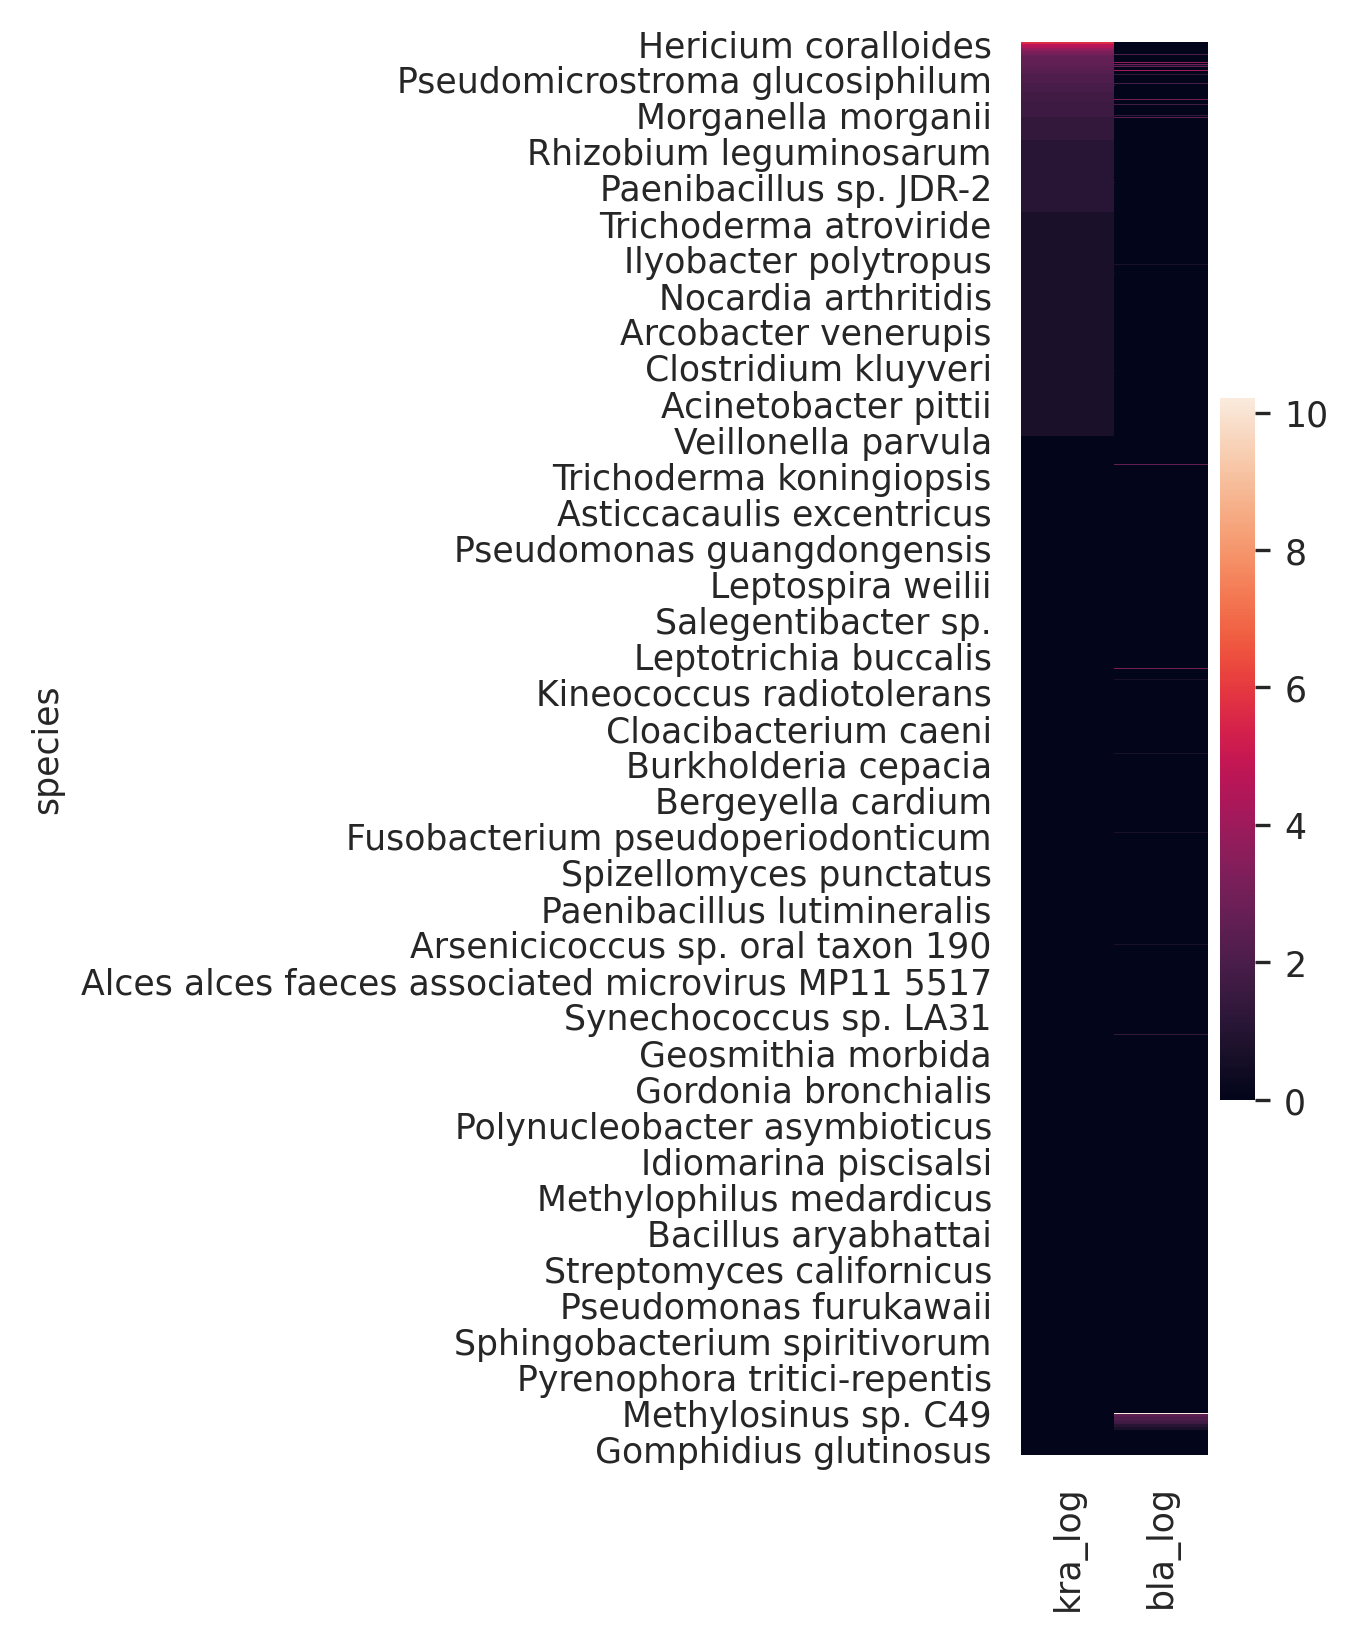

In [678]:
plt.figure(figsize=(1,6))

sns.heatmap(kb_all[['kra_log', 'bla_log']])

